<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Implémentez un modèle de scoring - P7</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Études des modèles |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist - OpenClassrooms</h4>
</div>

In [1]:
## General
import timeit
import re
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns

## Scikit Learn library
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, StratifiedKFold, KFold, 
                                     HalvingGridSearchCV, cross_validate, GridSearchCV)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
## LightGBM
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (precision_score, roc_auc_score, recall_score, 
                             f1_score, fbeta_score, confusion_matrix, roc_curve, 
                             )
from sklearn.feature_selection import SelectKBest, f_classif

## imbalanced-learn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE



## To use S3 files
import boto3
from sagemaker import get_execution_role

## SHapley Additive exPlanations.
#import shap
import pickle
## Lightweight pipelining in Python
import joblib


%matplotlib inline

#!pip3 install imblearn


In [2]:
from sklearn.pipeline import make_pipeline, Pipeline

In [3]:
data=pd.read_csv("df_current_clients.csv")
data.shape

(307507, 608)

In [4]:
data["SK_ID_CURR"]

0         100002.0
1         100003.0
2         100004.0
3         100006.0
4         100007.0
            ...   
307502    456251.0
307503    456252.0
307504    456253.0
307505    456254.0
307506    456255.0
Name: SK_ID_CURR, Length: 307507, dtype: float64

In [5]:
data.isnull().mean().sort_values()

SK_ID_CURR                                                  0.0
PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN                  0.0
PREV_NAME_CASH_LOAN_PURPOSE_Gasificationwatersupply_MEAN    0.0
PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN                      0.0
PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN                    0.0
                                                           ... 
ORGANIZATION_TYPE_Realtor                                   0.0
ORGANIZATION_TYPE_Religion                                  0.0
ORGANIZATION_TYPE_Restaurant                                0.0
ORGANIZATION_TYPE_Military                                  0.0
INSTAL_COUNT                                                0.0
Length: 608, dtype: float64

In [6]:
not_feats_columns  = ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']
[i for i in data.columns if i in not_feats_columns]  

['SK_ID_CURR', 'TARGET']

In [7]:
feats= [col for col in data.columns if col not in ['SK_ID_CURR', 'TARGET']]

In [8]:
X = data[feats]
Y = data.loc[:,"TARGET"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)

In [16]:
print("X_train: {} et y_train: {}".format(X_train.shape, y_train.shape))
print("---------------------")
print("X_test: {} et y_test: {}".format(X_test.shape, y_test.shape))

X_train: (246005, 606) et y_train: (246005,)
---------------------
X_test: (61502, 606) et y_test: (61502,)


In [10]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = ["roc_auc", "recall", "f1"]


classifiers = {
    "Random Forest" : RandomForestClassifier(),
    "LightGBM" : LGBMClassifier(),
    "Gradient Boosting" : GradientBoostingClassifier(),
    "LogisticRegression" : LogisticRegression(random_state=4),
    "xgboost" : xgb.XGBClassifier()
}

In [17]:
# List of metrics results for each models 
LIST_MODEL, LIST_RECALL, LIST_ROC_AUC, LIST_F1, LIST_DURATION  = ([] for i in range(5))

for key, clf in classifiers.items():
    
    start_time_model = timeit.default_timer()
    
    scores = cross_validate(clf, X_train, y_train, 
                            cv=stratified_kfold, scoring=scoring)
    
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    
    # Adding results into LIST
    LIST_MODEL.append(key)
    LIST_RECALL.append(round(scores.get("test_recall").mean(), 3))
    LIST_ROC_AUC.append(round(scores.get("test_roc_auc").mean(), 3))
    LIST_F1.append(round(scores.get("test_f1").mean(), 3))
    LIST_DURATION.append(end_time_model)

/home/bdiallo/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/bdiallo/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

In [21]:
list_result={"ROC_AUC":LIST_ROC_AUC, "F1": LIST_F1, "recall": LIST_RECALL}
list_result

{'ROC_AUC': [0.71, 0.777, 0.769, 0.572, 0.767],
 'F1': [0.002, 0.068, 0.04, 0.001, 0.105],
 'recall': [0.001, 0.036, 0.021, 0.0, 0.06]}

In [40]:
df_models_result= pd.DataFrame([LIST_ROC_AUC,LIST_F1,
                               LIST_RECALL], index=list_result.keys(), columns = LIST_MODEL)
df_models_result


,Random Forest,LightGBM,Gradient Boosting,LogisticRegression,xgboost
ROC_AUC,0.710,0.777,0.769,0.572,0.767
F1,0.002,0.068,0.040,0.001,0.105
recall,0.001,0.036,0.021,0.000,0.060


In [30]:
df_models_result=pd.read_csv("comp_model.csv", sep="\t", index_col=None)

In [44]:
#df_models_result.index=["ROC_AUC","F1", "recall"]
#df_models_result

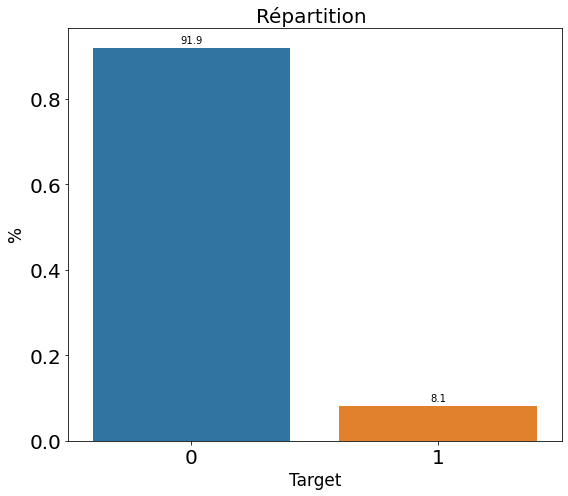

In [46]:
fig = plt.subplots(figsize=(8, 7))
SIZE=20
plot=sns.barplot(
    x=y_train.value_counts().index,
    y=y_train.value_counts(normalize=True),
)

for p in plot.patches:
    plot.annotate(format(p.get_height()*100, ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Répartition ", size=20)
plt.xlabel("Target", size=17)
plt.ylabel("%", size=17)

plt.rc('axes', labelsize=SIZE) 
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE) 
plt.rc('legend', fontsize=SIZE)
plt.tight_layout()
plt.savefig("fig/repartition_target.png")

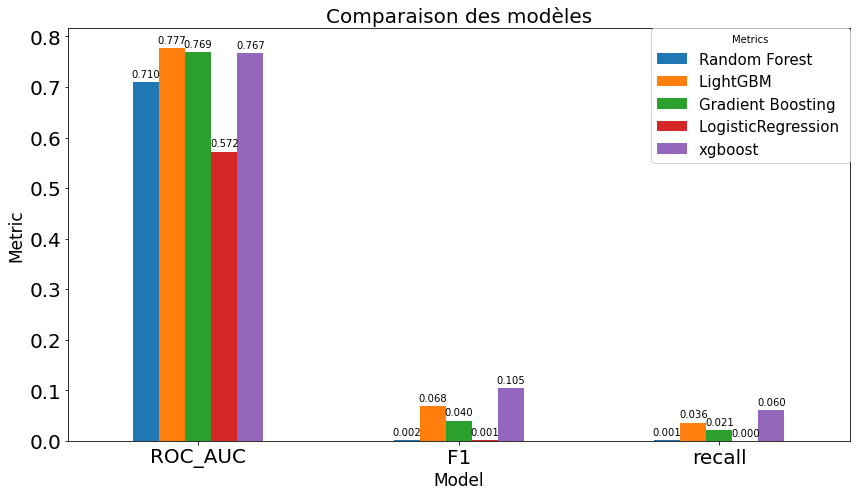

In [41]:
SIZE=18
plot= df_models_result.plot.bar(rot=0, figsize=[12,7])
plt.title("Comparaison des modèles", size=20)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0, title="Metrics", prop={'size':15})
plt.tight_layout()
plt.xlabel("Model", size=17)
plt.ylabel("Metric", size=17)

plt.rc('axes', labelsize=SIZE) 
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE) 
plt.rc('legend', fontsize=SIZE)
plt.tight_layout()
plt.savefig("fig/comparaison_model.png")

Dans ce résultat le modèle LightGBM est celui qui présente le meilleur résultat de ROC_AUC. Dans le kernel précédemment étudié  "<citation>" le modèle LightGBM a été optimisé et les resultats du ROC_AUC ont augmenté. Il a obtenue une valeur de de **0.79** en moyenne. avec les paramètres suivante :<br/>
    <div class="alert alert-block alert-success">
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1
    </div>
    
 En analysant les différents scoring on note que le modèle **xgboost** est celui qui a une meilleure réprésentation du recall et du F1. <br/>Cependant, on note une surreprésentation de la classe majoritaire donc pour résoudre ce déséquilibre, je choisi dans la suite de réanchantilloner en utilisant "**SMOTE**"

In [11]:
over = SMOTE(random_state=42)
X_train_new, y_train_new = over.fit_resample(X_train, y_train)

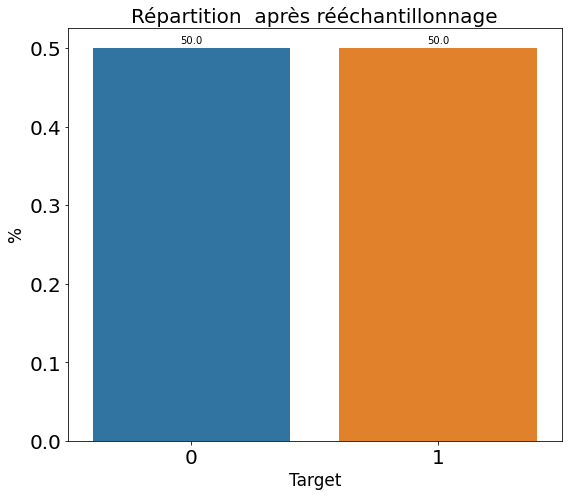

In [52]:
fig = plt.subplots(figsize=(8, 7))
SIZE=20
plot= sns.barplot(
    x=y_train_new.value_counts().index,
    y=y_train_new.value_counts(normalize=True),
)
for p in plot.patches:
    plot.annotate(format(p.get_height()*100, ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.title("Répartition  après rééchantillonnage", size=20)
plt.xlabel("Target", size=17)
plt.ylabel("%", size=17)

plt.rc('axes', labelsize=SIZE) 
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE) 
plt.rc('legend', fontsize=SIZE)
plt.tight_layout()
plt.savefig("fig/repartition_target_SMOTE.png")

In [12]:
X_train_set,X_valid_set, y_train_set,y_valid_set = train_test_split(
    X_train_new,y_train_new, test_size=0.2, random_state=42)

In [13]:
# List of metrics results for each models 
LIST_MODEL_2, LIST_RECALL_2, LIST_ROC_AUC_2, LIST_F1_2, LIST_DURATION_2  = ([] for i in range(5))

for key, clf in classifiers.items():
    
    start_time_model = timeit.default_timer()
    
    scores = cross_validate(clf, X_train_set, y_train_set, 
                            cv=stratified_kfold, scoring=scoring)
    
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    
    # Adding results into LIST
    LIST_MODEL_2.append(key)
    LIST_RECALL_2.append(round(scores.get("test_recall").mean(), 3))
    LIST_ROC_AUC_2.append(round(scores.get("test_roc_auc").mean(), 3))
    LIST_F1_2.append(round(scores.get("test_f1").mean(), 3))
    LIST_DURATION_2.append(end_time_model)

/home/bdiallo/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
list_result={"ROC_AUC":LIST_ROC_AUC_2, "F1": LIST_F1_2, "recall": LIST_RECALL_2}

df_models_result_2= pd.DataFrame([LIST_ROC_AUC_2,LIST_F1_2,
                               LIST_RECALL_2], index=list_result.keys(), columns = LIST_MODEL_2)
df_models_result_2

,Random Forest,LightGBM,Gradient Boosting,LogisticRegression,xgboost
ROC_AUC,0.983,0.980,0.975,0.594,0.979
F1,0.954,0.954,0.952,0.248,0.953
recall,0.912,0.913,0.910,0.162,0.918


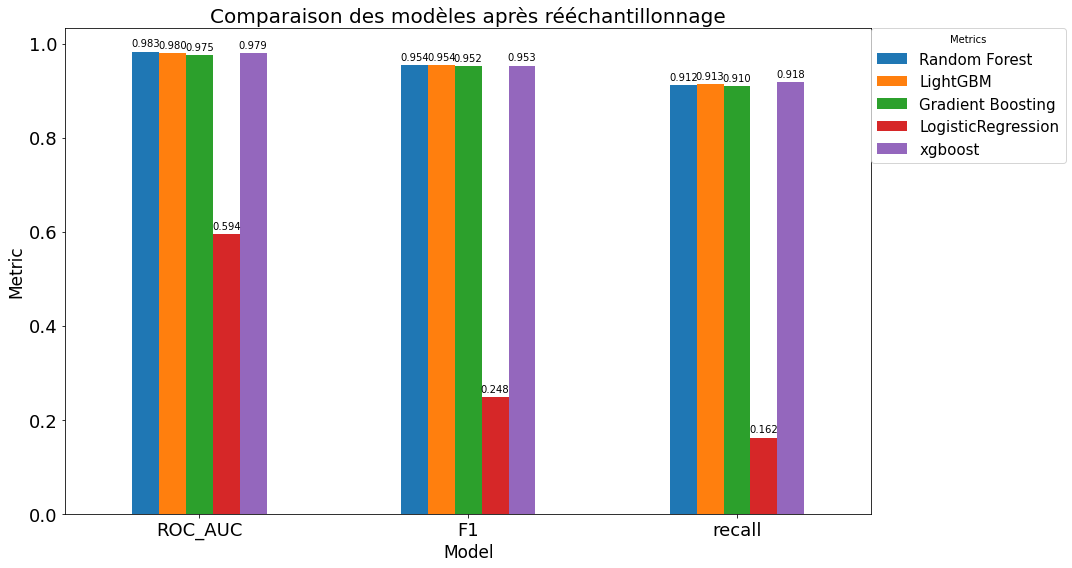

In [43]:
SIZE=18
plot= df_models_result_2.plot.bar(rot=0, figsize=[15,8])
plt.title("Comparaison des modèles après rééchantillonnage", size=20)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".3f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 8), textcoords="offset points")
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0, title="Metrics", prop={'size':15})
plt.tight_layout()
plt.xlabel("Model", size=17)
plt.ylabel("Metric", size=17)

plt.rc('axes', labelsize=SIZE) 
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE) 
plt.rc('legend', fontsize=SIZE)
plt.tight_layout()
plt.savefig("fig/comparaison_model_smote.png")

In [13]:
X_train_new.shape,X_train.shape

((452290, 606), (246005, 606))

In [7]:
X_valid_set.to_csv("X_valid_set.csv", header=True, encoding='utf-8')
X_train_set.to_csv("X_train_set.csv", header=True, encoding='utf-8')

In [55]:
y_valid_set.to_csv("y_valid_set.csv", header=True, encoding='utf-8')
y_train_set.to_csv("y_train_set.csv", header=True, encoding='utf-8')

# Recherche des meilleurs hyperparamètres

## RandomForest

In [14]:
parameters_1 = {'n_estimators' : [100], 'min_samples_leaf' : [1,2,3,4,5], 
              'max_features': [int(x) for x in np.linspace(1,10,5)]}

Randomgrid = GridSearchCV(RandomForestClassifier(random_state=4),
                        param_grid = parameters_1, verbose=-1,cv=stratified_kfold,
                        scoring='roc_auc')

In [15]:
Randomgrid.fit(X_train_set, y_train_set)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=4),
             param_grid={'max_features': [1, 3, 5, 7, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'n_estimators': [100]},
             scoring='roc_auc', verbose=-1)

In [16]:
import pickle

filename = 'RandomForest.pkl'
with open(filename, 'wb') as file:
    pickle.dump(Randomgrid,file)

joblib.dump(Randomgrid, 'RandomForest.joblib')

## LightGBM

In [16]:
parameters_2={'max_depth': [7, 8, 9],
            'num_leaves': [32, 34],
            'learning_rate': [0.01,0.02,0.03],
            'colsample_bytree':[0.8,0.9, 1]}


LightGBMgrid = GridSearchCV(LGBMClassifier(random_state=4),
                        param_grid = parameters_2,verbose=-1,cv=stratified_kfold,
                        scoring='roc_auc')

In [17]:
LightGBMgrid.fit(X_train_set, y_train_set)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LGBMClassifier(random_state=4),
             param_grid={'colsample_bytree': [0.8, 0.9, 1],
                         'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [7, 8, 9], 'num_leaves': [32, 34]},
             scoring='roc_auc', verbose=-1)

In [18]:
filename = 'LightGBM.pkl'
with open(filename, 'wb') as file:
    pickle.dump(LightGBMgrid,file)

## XGBoost

In [6]:
n_estimators = [100, 200,300]
subsample=[0.7, 0.8]
learning_rate=[0.1,0.2]

parameters = {'n_estimators': n_estimators,
                 'subsample':subsample,
                 'learning_rate':learning_rate}

In [17]:
xgbgrid = GridSearchCV(xgb.XGBClassifier(),
                        param_grid = parameters,verbose=-1,cv=stratified_kfold,
                        scoring='roc_auc')

In [18]:
xgbgrid.fit(X_train_set, y_train_set)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.1, 0.2], 'n_estimators': [100],
                         'subsample': [0.7, 0.8]},
             scoring='roc_auc', verbose=-1)

In [34]:
xgbgrid.best_score_,xgbgrid.best_params_

(0.9795734561982168,
 {'learning_rate': 0.2, 'n_estimators': 100, 'subsample': 0.7})

In [27]:
roc_auc_score(xgbgrid.predict(X_valid_set), y_valid_set)

0.9582815031298817

In [28]:
f1_score(xgbgrid.predict(X_valid_set), y_valid_set)

0.9537687171767085

In [ ]:
filename = 'xgboost.pkl'
with open(filename, 'wb') as file:
    pickle.dump(xgbgrid,file)

In [37]:
joblib.dump(xgbgrid, 'xgboost.joblib')

['xgboost.joblib']

## Récaputilatif des résultats

In [23]:
##mlflow
#from mlflow.models.signature import infer_signature
#import mlflow.sklearn
#signature_2 = infer_signature(X_train_set, y_train_set)
#mlflow.sklearn.save_model(Randomgrid_model, 'mlflow_model_random', signature=signature_2)


#mlflow models serve -m mlflow_model_random/ ##pour le deploiement faire dans le terminale
## créer  http://127.0.0.1:5000 (35665)
#curl http://127.0.0.1:5000/invocations -H 'Content-Type: application/json' -d '{"data": [donnnee]}'

In [20]:
filename_RF = 'RandomForest.pkl'
filename_xgb= 'xgboost.pkl'
Randomgrid = pickle.load(open(filename_RF, 'rb'))
xgbgrid = pickle.load(open(filename_xgb, 'rb'))

In [27]:
models_score = pd.DataFrame({})    
models_score = models_score.append(pd.DataFrame(
    {'Models' : ['LightGBM','xgboost','RandomForest'],
     'Training_set' : [LightGBMgrid.best_score_, Randomgrid.best_score_, xgbgrid.best_score_],
     'Validation_set_f1' : [f1_score(LightGBMgrid.predict(X_valid_set), y_valid_set),
                            f1_score(Randomgrid.predict(X_valid_set), y_valid_set),
                            f1_score(xgbgrid.predict(X_valid_set), y_valid_set)],
     'Validation_set_roc_auc' : [roc_auc_score(LightGBMgrid.predict(X_valid_set), y_valid_set),
                                 roc_auc_score(Randomgrid.predict(X_valid_set), y_valid_set),
                                 roc_auc_score(xgbgrid.predict(X_valid_set), y_valid_set)],
     'Validation_set_recall' : [recall_score(LightGBMgrid.predict(X_valid_set), y_valid_set),
                                 recall_score(Randomgrid.predict(X_valid_set), y_valid_set),
                                recall_score(xgbgrid.predict(X_valid_set), y_valid_set)]}),
                                   ignore_index=True)
models_score

,Models,Training_set,Validation_set_f1,Validation_set_roc_auc,Validation_set_recall
0,LightGBM,0.975941,0.949833,0.956190,0.999341
1,xgboost,0.983879,0.956049,0.960144,0.994346
2,RandomForest,0.979573,0.953769,0.958282,0.994059


In [22]:
models_score.to_csv('models_score.csv')

In [30]:
(TN, FP, FN, TP)=confusion_matrix(xgbgrid.predict(X_valid_set), y_valid_set, labels=[0, 1]).ravel()
#fonction_cout_metier=10*FN+FP

In [35]:
(TN, TP, FP, FN)

(44937, 41498, 3775, 248)